# Time Series Analysis (TSA) in Python
Linear Models to GARCH

http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

In [1]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

### Plotting a time series and analyzing the serial correlation visually

In [2]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)

        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

# 1. White noise and random walks

## 1.1 Random series

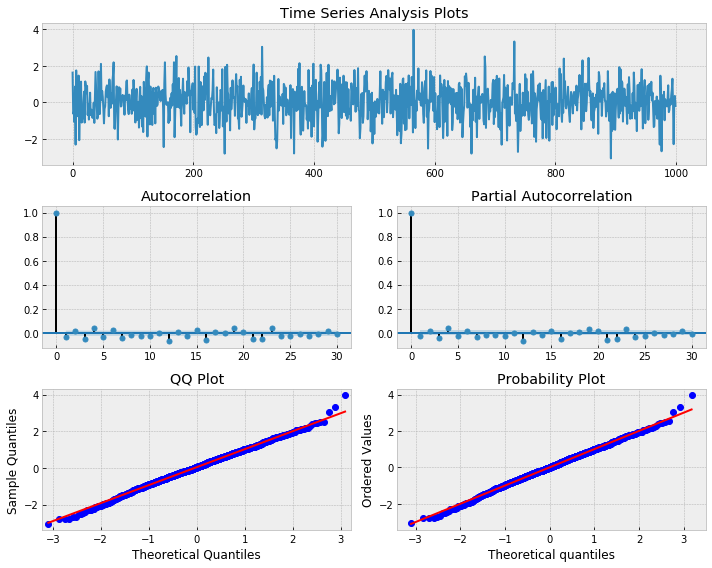

In [3]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [4]:
print("Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))

Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


## 1.2 Random walk

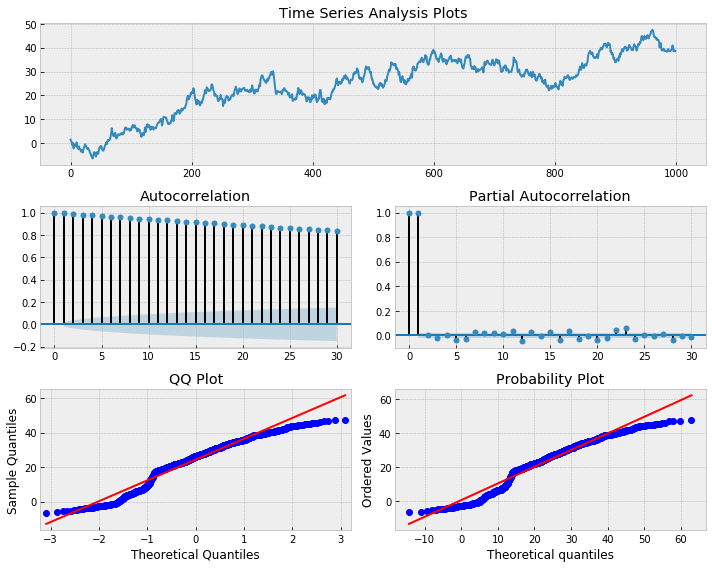

In [5]:
np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

A random walk is xt = xt-1 + wt. Using algebra we can say that xt - xt-1 = wt. Thus the first differences of our random walk series should equal a white noise process! We can use the "np.diff()" function on our TS and see if this holds. 

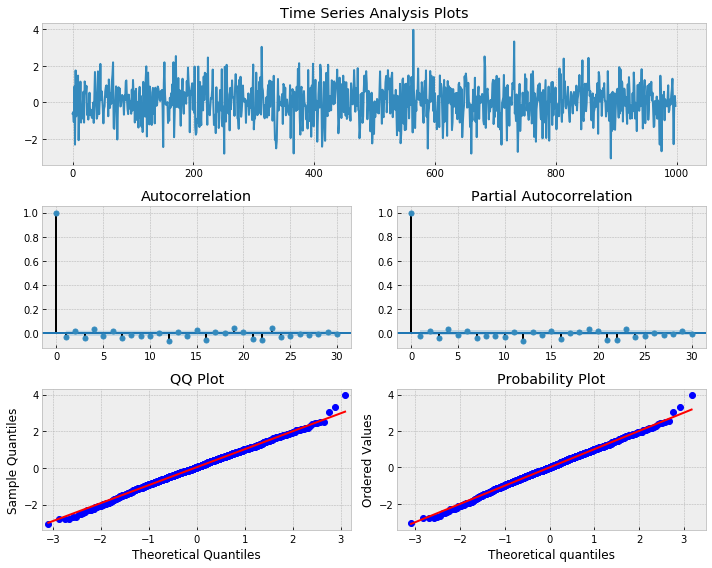

In [6]:
# First difference of simulated Random Walk series

_ = tsplot(np.diff(x), lags=30)

## 1.3 Financial data

In [7]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

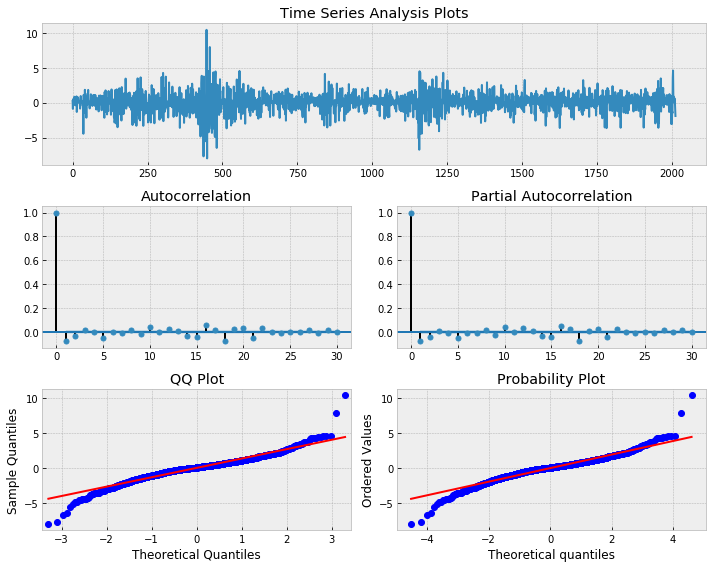

In [8]:
# First difference of SPY prices
_ = tsplot(np.diff(data.SPY), lags=30)

The process is close to normality but with 'heavy tails'. There also appears to be some significant serial correlation in the ACF, and PACF plots around lags 1, 5?, 16?, 18 and 21. This means that there should be better models to describe the actual price change process. 

# 2. Linear models

In this model the value of the dependent variable is determined by the beta coefficients and a singular independent variable, time. 

$y_t=b_0+b_1 t+\epsilon_t$

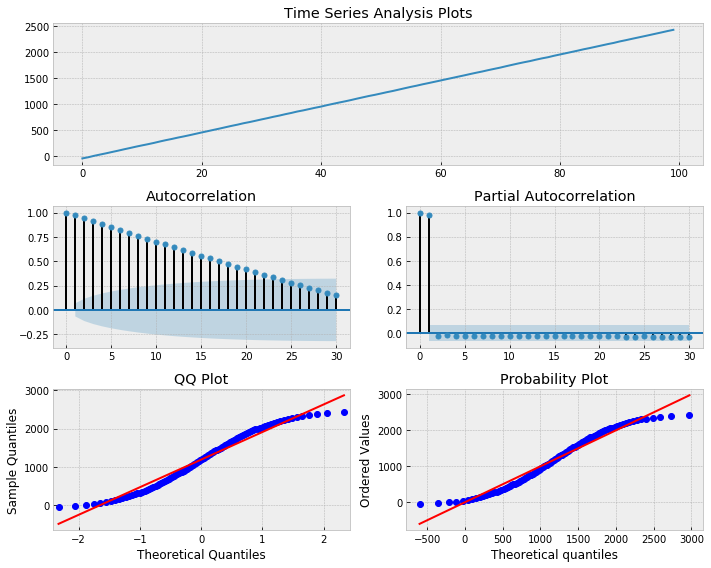

In [9]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y, lags=30)  

Here we can see that the residuals of the model are correlated and linearly decreasing as a function of the lag. The distribution is approximately normal. Before using this model to make predictions we would have to account for and remove the obvious autocorrelation present in the series. The significance of the PACF at lag 1 indicates that an autoregressive model may be appropriate.

# 3. Log-linear models

A data curve may look like this:

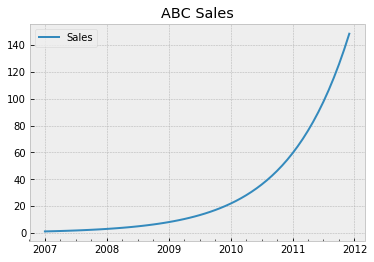

In [10]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

And by taking the natural logarithm of the data:

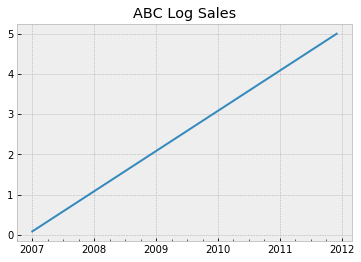

In [11]:
# ABC log sales 

with plt.style.context('bmh'):
    pd.Series(np.log(sales), index=idx).plot()
    plt.title('ABC Log Sales')

# 4. Autoregressive Models - AR(p)

## 4.1 Simulate an AR(1) process with alpha = 0.6

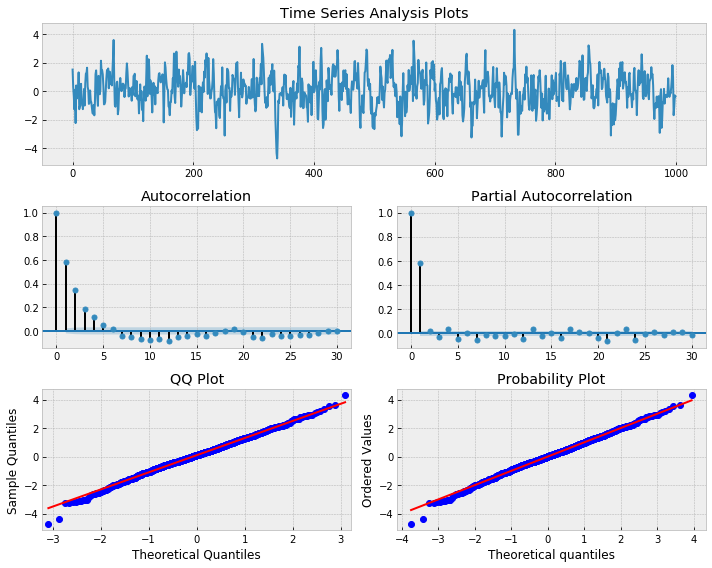

In [12]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

The distribution of our simulated AR(1) model is normal. There is significant serial correlation between lagged values especially at lag 1 as evidenced by the PACF plot. 

Now we can fit an AR(p) model using Python's statsmodels. First we fit the AR model to our simulated data and return the estimated alpha coefficient. Then we use the statsmodels function "select_order()" to see if the fitted model will select the correct lag.

**If the AR model is correct the estimated alpha coefficient will be close to our true alpha of 0.6 and the selected order will equal 1.**

In [13]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'
      .format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'
      .format(a, true_order))

CPU times: user 20.6 s, sys: 189 ms, total: 20.8 s
Wall time: 10.5 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


## 4.2 Simulate an AR(2) process

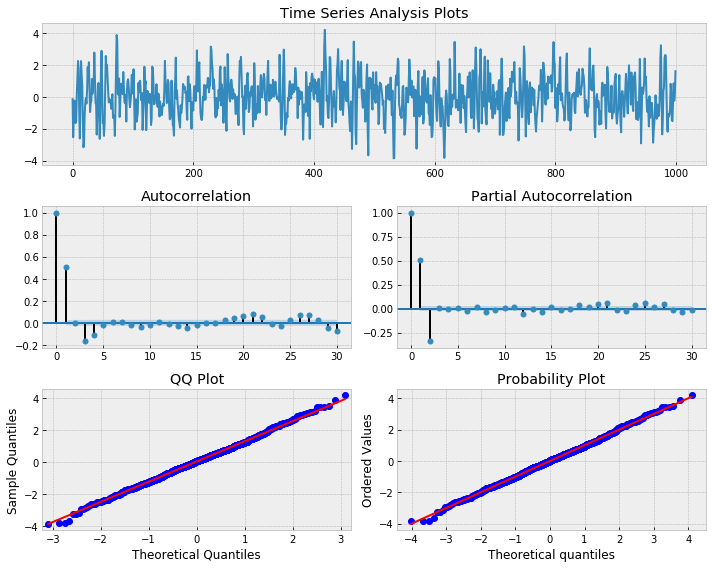

In [14]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30)

In [15]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
    .format(mdl.params[0],mdl.params[1], est_order))
print('\ntrue coefs = {} | true order = {}'
    .format([.666,-.333], true_order))
  
# coef estimate: 0.6291 -0.3196 | best lag order = 2
# true coefs = [0.666, -0.333] | true order = 2


coef estimate: 0.6760 -0.3393 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


## 4.3 Fit the <a href='#1.3-Financial-data'>financial data</a>

In [16]:
# Select best lag order for MSFT returns

max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = {}'.format(est_order))

# best estimated lag order = 23

/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best estimated lag order = 23


The best order is 23 lags or 23 parameters! Any model with this many parameters is unlikely to be useful in practice. Clearly there is more complexity underlying the returns process than this model can explain.

# 5. Moving Average Models

MA(q) models are very similar to AR(p) models. The difference is that the MA(q) model is a linear combination of past white noise error terms as opposed to a linear combo of past observations like the AR(p) model. The motivation for the MA model is that we can observe "shocks" in the error process directly by fitting a model to the error terms. In an AR(p) model these shocks are observed indirectly by using the ACF on the series of past observations. The formula for an MA(q) model is:

## 5.1 Simulate an MA(1) process

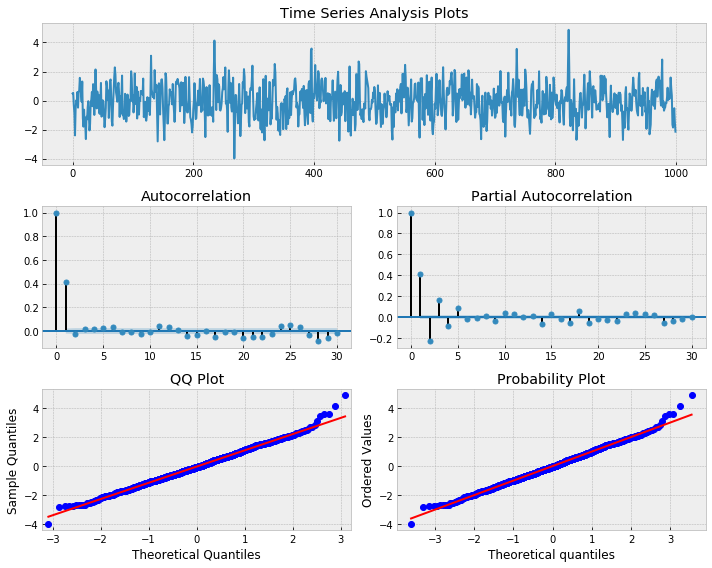

In [17]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

The ACF function shows that lag 1 is significant which indicates that a MA(1) model may be appropriate for our simulated series. I'm not sure how to interpret the PACF showing significance at lags 2, 3, and 4 when the ACF only shows significance at lag 1. Regardless we can now attempt to fit a MA(1) model to our simulated data. We can use the same statsmodels "ARMA()" function specifying our chosen orders. We call on its "fit()" method to return the model output. 

In [18]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1390.513
Method:                           mle   S.D. of innovations              0.972
Date:                Thu, 13 Dec 2018   AIC                           2785.025
Time:                        12:53:46   BIC                           2794.841
Sample:                             0   HQIC                          2788.756
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5874      0.026     22.762      0.000       0.537       0.638
                                    Roots                                    
                  Real          Imaginary           M

## 5.2 Simulate an MA(3) process with betas 0.6, 0.4, 0.2

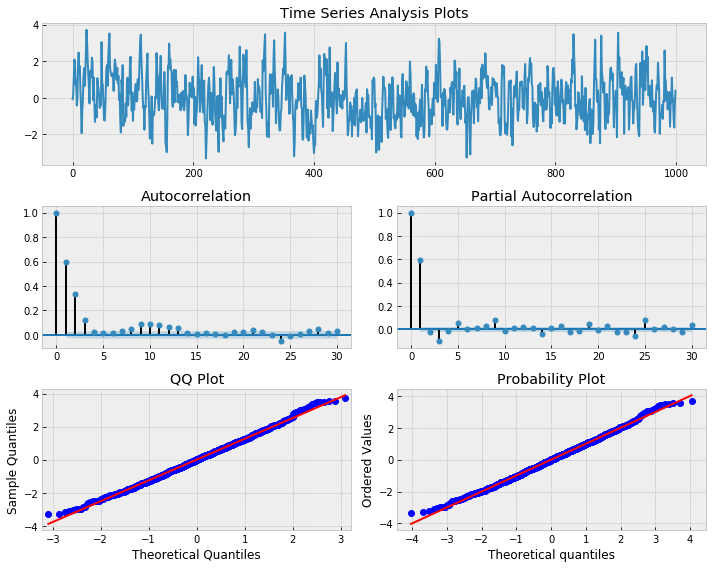

In [19]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [20]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1427.038
Method:                           mle   S.D. of innovations              1.008
Date:                Thu, 13 Dec 2018   AIC                           2862.075
Time:                        12:53:46   BIC                           2881.706
Sample:                             0   HQIC                          2869.536
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6025      0.031     19.322      0.000       0.541       0.664
ma.L2.y        0.4060      0.034     11.806      0.000       0.339       0.473
ma.L3.y        0.1683      0.031      5.420      0.0

The model was able to estimate the real coefficients effectively. Our 95% confidence intervals also contain the true parameter values of 0.6, 0.4, and 0.3.

## 5.3 Fit an MA(3) model to the <a href='#1.3-Financial-data'>financial data</a>

                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2013
Model:                     ARMA(0, 3)   Log Likelihood                5756.952
Method:                           mle   S.D. of innovations              0.014
Date:                Thu, 13 Dec 2018   AIC                         -11505.905
Time:                        12:53:47   BIC                         -11483.475
Sample:                             0   HQIC                        -11497.672
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0959      0.022     -4.314      0.000      -0.139      -0.052
ma.L2.SPY     -0.0737      0.023     -3.256      0.001      -0.118      -0.029
ma.L3.SPY      0.0274      0.022      1.260      0.2

/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


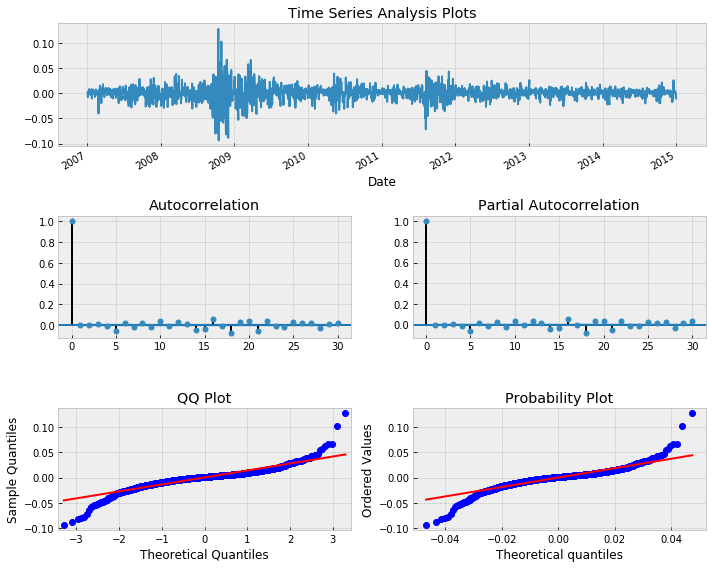

In [21]:
# Fit MA(3) to SPY returns

max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

 The heaviness of the tails makes me think this isn't the best model.

# 6. Autoregressive Moving Average Models - ARMA(p, q)

The ARMA model is simply the merger between AR(p) and MA(q) models. Let's recap what these models represent to us from a quant finance perspective: 

* AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets. 
* MA(q) models try to capture (explain) the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the observation process e.g. Surprise earnings, A terrorist attack, etc.

ARMA's weakness is that it ignores the volatility clustering effects found in most financial time series. 

## 6.1 Simulate an ARMA(2, 2) model

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7076.176
Method:                           mle   S.D. of innovations              0.996
Date:                Thu, 13 Dec 2018   AIC                          14162.352
Time:                        12:53:48   BIC                          14194.938
Sample:                             0   HQIC                         14173.773
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4730      0.051      9.338      0.000       0.374       0.572
ar.L2.y       -0.2645      0.015    -17.489      0.000      -0.294      -0.235
ma.L1.y        0.5224      0.052     10.089      0.0

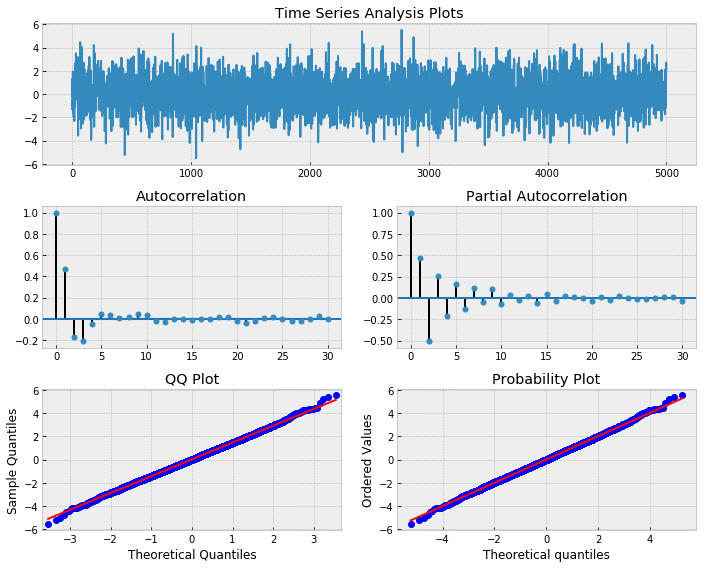

In [22]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

## 6.2 Simulate an ARMA(3, 2) model

After, we cycle through a non trivial number of combinations of p, q to fit an ARMA model to our simulated series. We choose the best combination based on which model produces the lowest [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion)

aic: 14212.01026 | order: (3, 2)


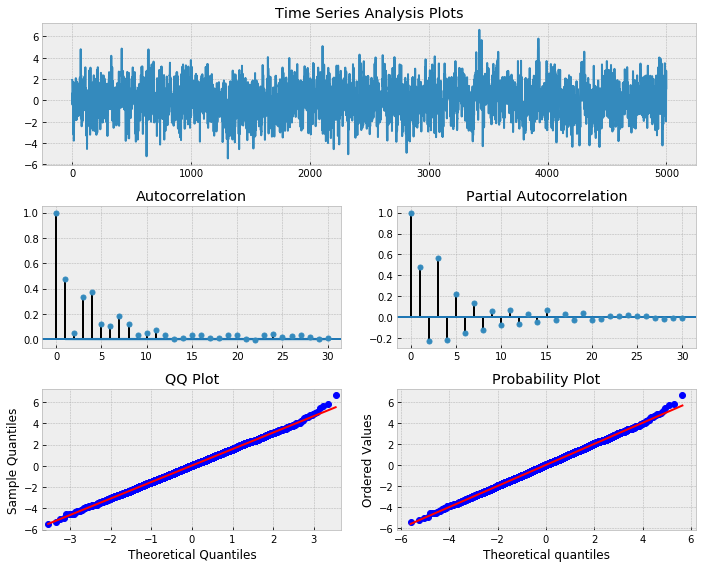

In [23]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# aic: 14108.27213 | order: (3, 2)

## 6.3 Fit an ARMA model to <a href='#1.3-Financial-data'>financial data</a>

In [24]:
# Fit ARMA model to SPY returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# aic: -11518.22902 | order: (4, 4)

/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A da

aic: -11520.47363 | order: (4, 3)


We plot the residuals:

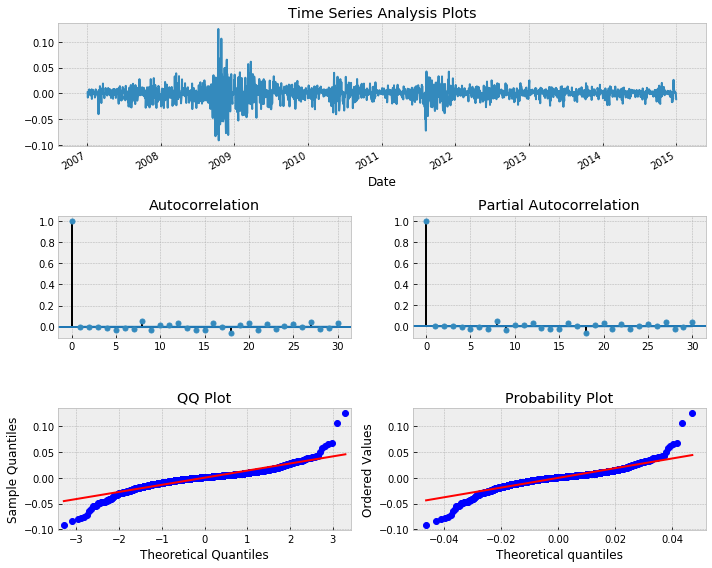

In [25]:
_ = tsplot(best_mdl.resid, lags=max_lag)

The ACF and PACF are showing no significant autocorrelation. The QQ and Probability Plots show the residuals are approximately normal with heavy tails. However, this model's residuals do NOT look like white noise! Look at the highlighted areas of obvious conditional heteroskedasticity (conditional volatility) that the model has not captured. 

# 7. Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

ARIMA is a natural extension to the class of ARMA models. As previously mentioned many of our TS are not stationary, however they can be made stationary by differencing. We saw an example of this when we took the first difference of a Guassian random walk and proved that it equals white noise. Said another way, we took the nonstationary random walk and transformed it to stationary white noise by first-differencing.

Without diving too deeply into the equation, just know the "d" references the number of times we are differencing the series. A side note, in Python we must use np.diff() function if we need to difference a series more than once. The pandas functions DataFrame.diff()/Series.diff() only takes the first difference of a dataframe/series and does not implement the recursive differencing needed in TSA.  

## 7.1 Fit ARIMA(p, d, q) model to  <a href='#1.3-Financial-data'>financial data</a>

/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A da

/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A da

/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information a

aic: -11520.47363 | order: (4, 0, 3)


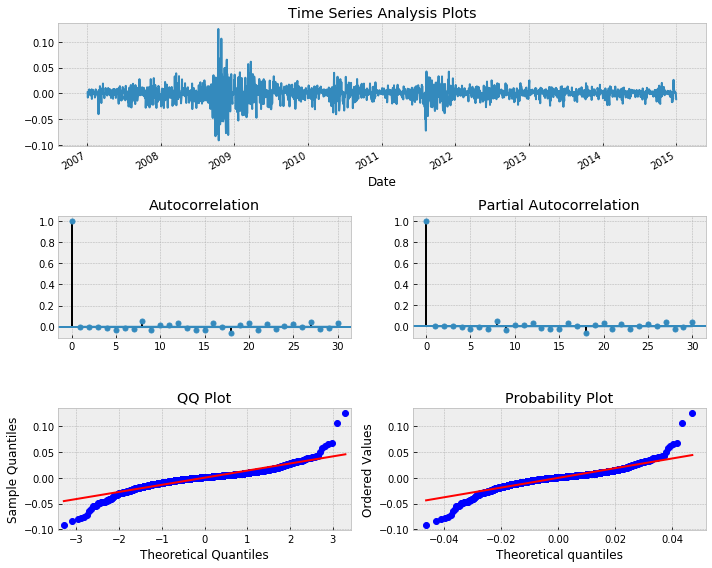

In [35]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

The result is essentially identical to the ARMA(4, 4) model we fit above. Clearly this ARIMA model has not explained the conditional volatility in the series either! 

## 7.2 Forecasting

In [36]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2014-12-31,0.001367,-0.025642,-0.034129,0.028376,0.036863
2015-01-01,-0.000068,-0.027192,-0.035715,0.027056,0.035579
2015-01-02,0.000230,-0.026954,-0.035495,0.027413,0.035954
2015-01-03,0.000454,-0.026736,-0.035280,0.027644,0.036187
2015-01-04,-0.000608,-0.027798,-0.036342,0.026583,0.035126


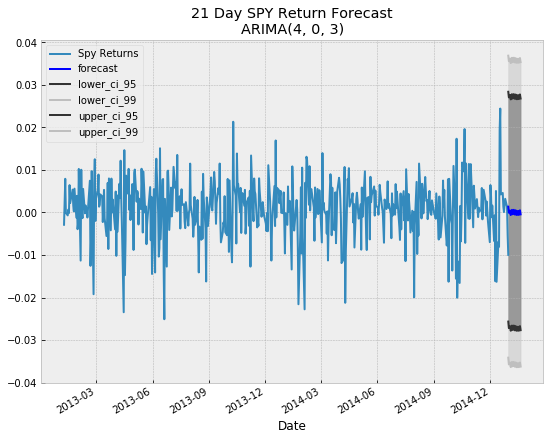

In [45]:
# Plot 21 day forecast for SPY returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
# pred = best_mdl.predict(ts.index[0], ts.index[-1])
# pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

# 8. Autoregressive Conditionally Heteroskedastic Models - ARCH(p)

ARCH(p) models can be thought of as simply an AR(p) model applied to the variance of a time series. Another way to think about it, is that the variance of our time series NOW at time t, is conditional on past observations of the variance in previous periods.

## 8.1 Simulate ARCH(1) series

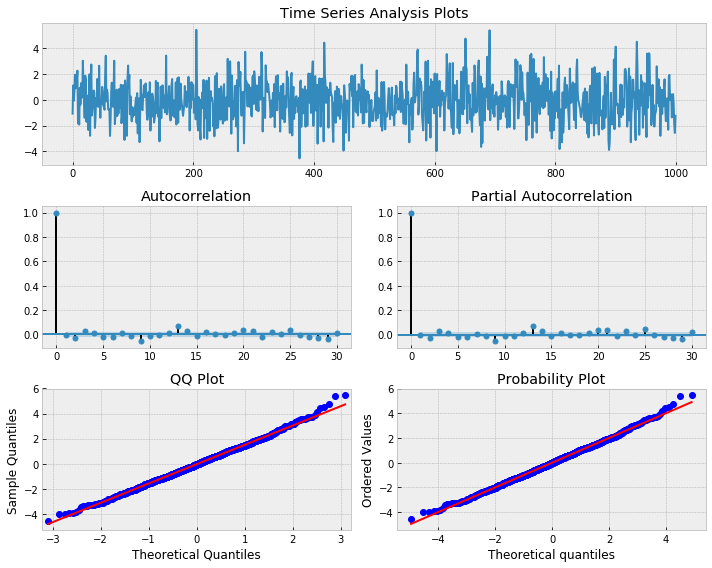

In [69]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

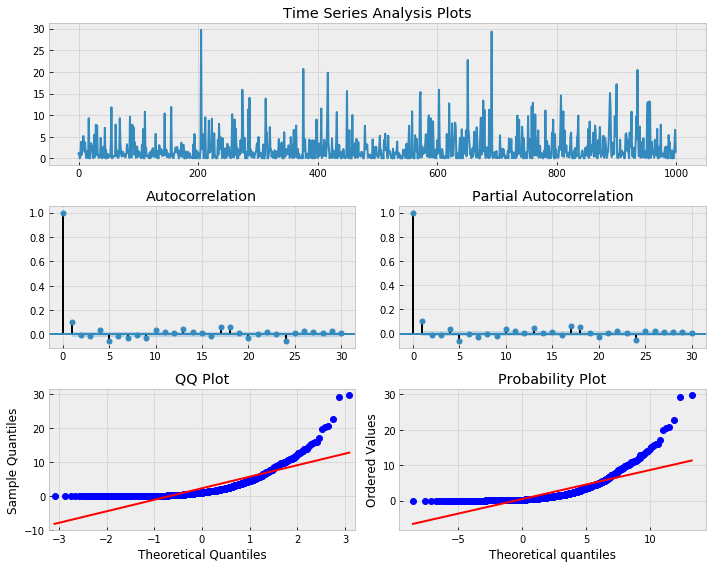

In [70]:
# simulated ARCH(1) series, looks like white noise
tsplot(Y**2, lags=30)

Notice the ACF, and PACF  seem to show significance at lag 1 indicating an AR(1) model for the variance may be appropriate. 

# 9. Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)

Simply put GARCH(p, q)  is an ARMA model applied to the variance of a time series i.e., it has an autoregressive term and a moving average term. The AR(p) models the variance of the residuals (squared errors) or simply our time series squared. The MA(q) portion models the variance of the process.

## 9.1 Simulating a GARCH(1, 1) process

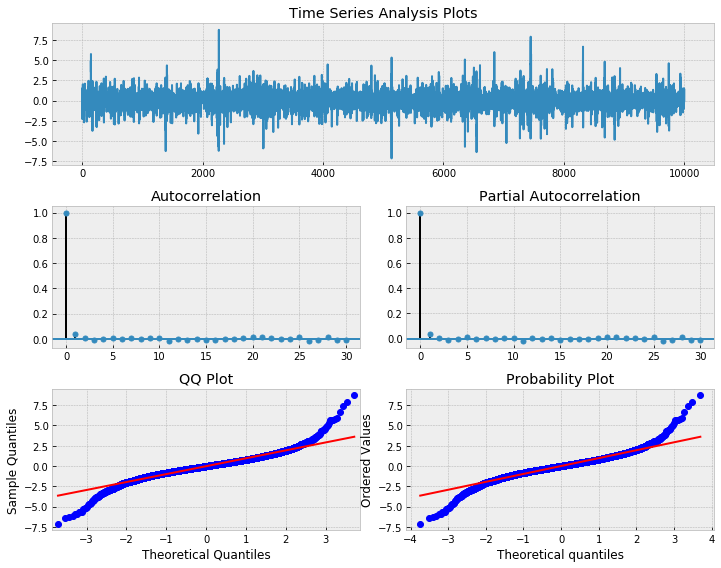

In [72]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

Process squared:

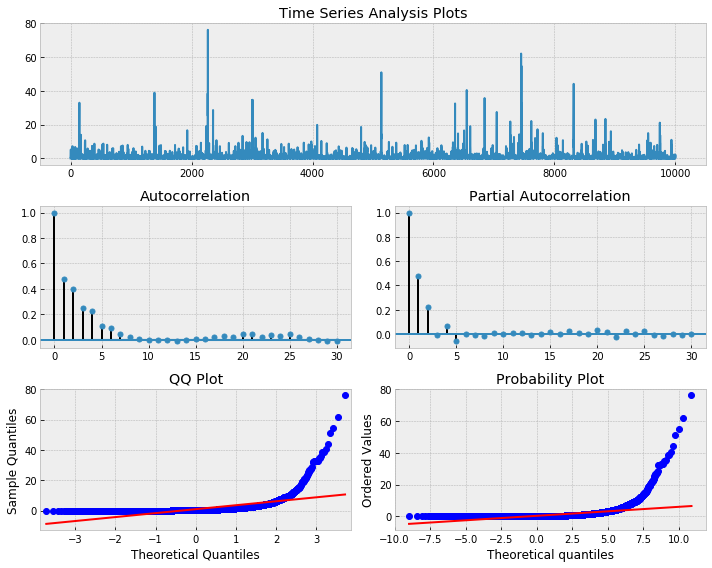

In [73]:
_ = tsplot(eps**2, lags=30)

There is clearly autocorrelation present and the significance of the lags in both the ACF and PACF indicate we need both AR and MA components for our model. Let's see if we can recover our process parameters using a GARCH(1, 1) model. Here we make use of the arch_model function from the ARCH package. 

In [74]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592659128462
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.303267318555
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Thu, Dec 13 2018   Df Residuals:                     9996
Time:      

## 9.2 Fit GARCH model to  <a href='#1.3-Financial-data'>financial data</a>

In [76]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.SPY.ix['2012':'2015']
res_tup = _get_best_model(TS)
best_aic, best_order, best_mdl = res_tup

# aic: -5255.56673 | order: (3, 0, 2)

/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:

/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A da

/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A da

aic: -5255.56833 | order: (3, 0, 2)


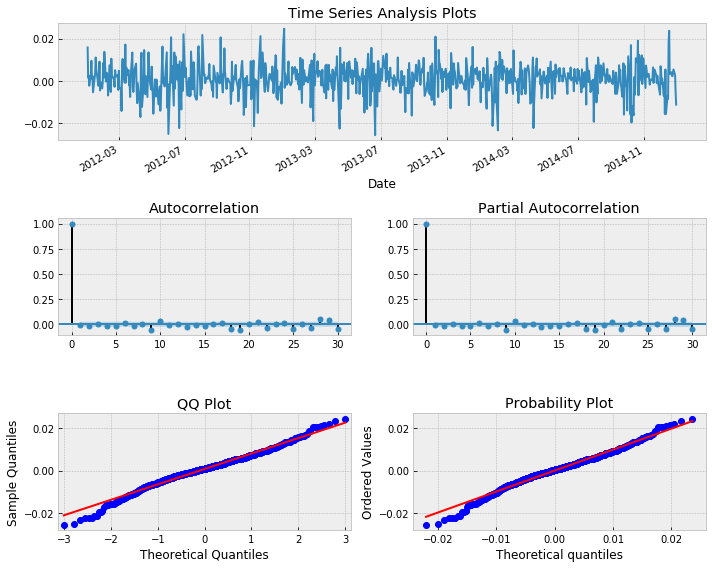

In [92]:
_ = tsplot(best_mdl.resid, lags=30)

Looks like white noise. 

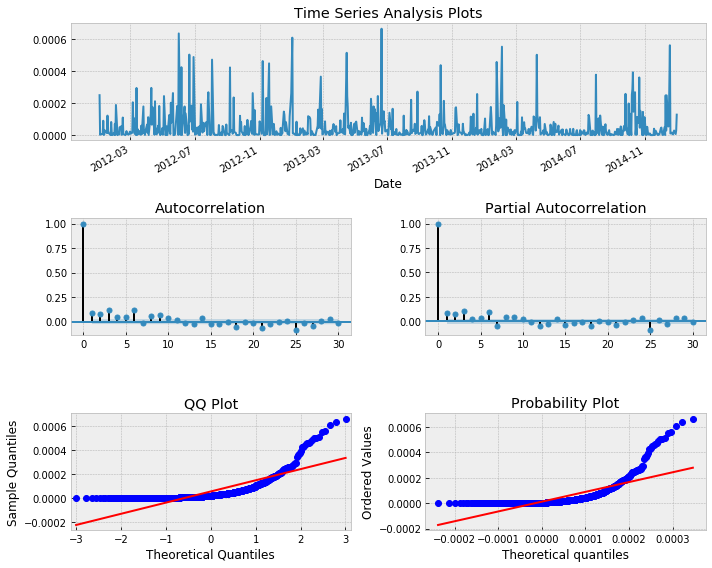

In [93]:
_ = tsplot(best_mdl.resid**2, lags=30)

Squared residuals show autocorrelation. Let's fit a GARCH model and see how it does. 

In [96]:
# Now we can fit the arch model using the best fit arima model parameters
order = (4, 0, 4)
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                      -0.910
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.910
Vol Model:                            GARCH   Log-Likelihood:                2041.15
Distribution:      Standardized Student's t   AIC:                          -4060.30
Method:                  Maximum Likelihood   BIC:                          -4009.42
                                              No. Observations:                  754
Date:                      Thu, Dec 13 2018   Df Residuals:                      743
Time:                              13:15:34   Df Model:                           11
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

/home/lucia/program_files/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Convergence warnings can occur when dealing with very small numbers. Multiplying the numbers by factors of 10 to scale the magnitude can help when necessary, however for this demonstration it isn't necessary. Below are the model residuals. 

* Total characters added during the window
* Total characters deleted during the window


* Number of each type of operations during the window


* Number of operations done in a "shared" superparagraph during the window
* Number of operations done in a "shared" superparagraph during the window / Total number of total operations done during the window